In [1]:
from helpers import get_fl_results_by_site, get_results_by_site

from meps_model import DeepNN

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re


In [2]:
cutoffs = list(map(lambda x: x / 100.0, range(10, 60, 5)))

In [3]:
!ls overall_weighted_logs/lightning_logs/version_0

checkpoints  metrics.csv


In [4]:
#First summarize the global model
global_res = get_results_by_site('_standard_logs', DeepNN(81), cutoffs, ['overall'])
weighted_global_res = get_results_by_site('_weighted_logs', DeepNN(81), cutoffs, ['overall'])

global_df = pd.merge(global_res, weighted_global_res, left_index=True, right_index=True, suffixes=('_std', '_weighted'))

Found checkpoint file:overall_standard_logs/lightning_logs/version_0/checkpoints/epoch=21-step=286.ckpt
Found checkpoint file:overall_weighted_logs/lightning_logs/version_0/checkpoints/epoch=20-step=273.ckpt


In [5]:
#Next summarize the site-specific models
site_res = get_results_by_site('_standard_logs', DeepNN(81), cutoffs, ['site_1', 'site_2', 'site_3'])
weighted_site_res = get_results_by_site('_weighted_logs', DeepNN(81), cutoffs, ['site_1', 'site_2', 'site_3'])

site_df = pd.merge(site_res, weighted_site_res, left_index=True, right_index=True, suffixes=('_site_std', '_site_weighted'))

Found checkpoint file:site_1_standard_logs/lightning_logs/version_0/checkpoints/epoch=30-step=155.ckpt
Found checkpoint file:site_2_standard_logs/lightning_logs/version_0/checkpoints/epoch=35-step=180.ckpt
Found checkpoint file:site_3_standard_logs/lightning_logs/version_0/checkpoints/epoch=31-step=160.ckpt
Found checkpoint file:site_1_weighted_logs/lightning_logs/version_0/checkpoints/epoch=28-step=145.ckpt
Found checkpoint file:site_2_weighted_logs/lightning_logs/version_0/checkpoints/epoch=27-step=140.ckpt
Found checkpoint file:site_3_weighted_logs/lightning_logs/version_0/checkpoints/epoch=21-step=110.ckpt


In [6]:
#The FL results are summarized next 
fl_res = get_fl_results_by_site("nvflare_wkdir", DeepNN(81), cutoffs, ['site_1', 'site_2', 'site_3'], use_best=False)
weighted_fl_res = get_fl_results_by_site("nvflare_weighted_wkdir", DeepNN(81), cutoffs, ['site_1', 'site_2', 'site_3'], use_best=False)

fl_df = pd.merge(fl_res, weighted_fl_res, left_index=True, right_index=True, suffixes=('_fl_std', '_fl_weighted'))

Found checkpoint file:nvflare_wkdir/server/simulate_job/app_server/FL_global_model.pt
Found checkpoint file:nvflare_weighted_wkdir/server/simulate_job/app_server/FL_global_model.pt


In [7]:
fl_res

,bacc,eo
site_1,0.757534,0.813954
site_2,0.760666,0.933870
site_3,0.809909,0.842607


In [8]:
#Finally combine the per-site results into a table

In [9]:
comb_df = pd.merge(site_df, fl_df, left_index=True, right_index=True)

In [10]:
comb_df

,bacc_site_std,eo_site_std,bacc_site_weighted,eo_site_weighted,bacc_fl_std,eo_fl_std,bacc_fl_weighted,eo_fl_weighted
site_1,0.754566,0.744186,0.771537,0.767442,0.757534,0.813954,0.741857,0.809524
site_2,0.780729,0.825553,0.762602,0.980415,0.760666,0.933870,0.760950,0.979680
site_3,0.803214,0.906233,0.799190,0.938842,0.809909,0.842607,0.797216,0.976658


In [11]:
global_df

,bacc_std,eo_std,bacc_weighted,eo_weighted
overall,0.778851,0.739033,0.756479,0.98248


In [12]:
comb_df.reset_index(inplace=True)

In [13]:
melted_comb_df = comb_df.melt(id_vars=['index'])

In [14]:
melted_comb_df[['measure', 'model', 'type']] = melted_comb_df['variable'].str.split('_', expand=True)
melted_comb_df.head()

,index,variable,value,measure,model,type
0,site_1,bacc_site_std,0.754566,bacc,site,std
1,site_2,bacc_site_std,0.780729,bacc,site,std
2,site_3,bacc_site_std,0.803214,bacc,site,std
3,site_1,eo_site_std,0.744186,eo,site,std
4,site_2,eo_site_std,0.825553,eo,site,std


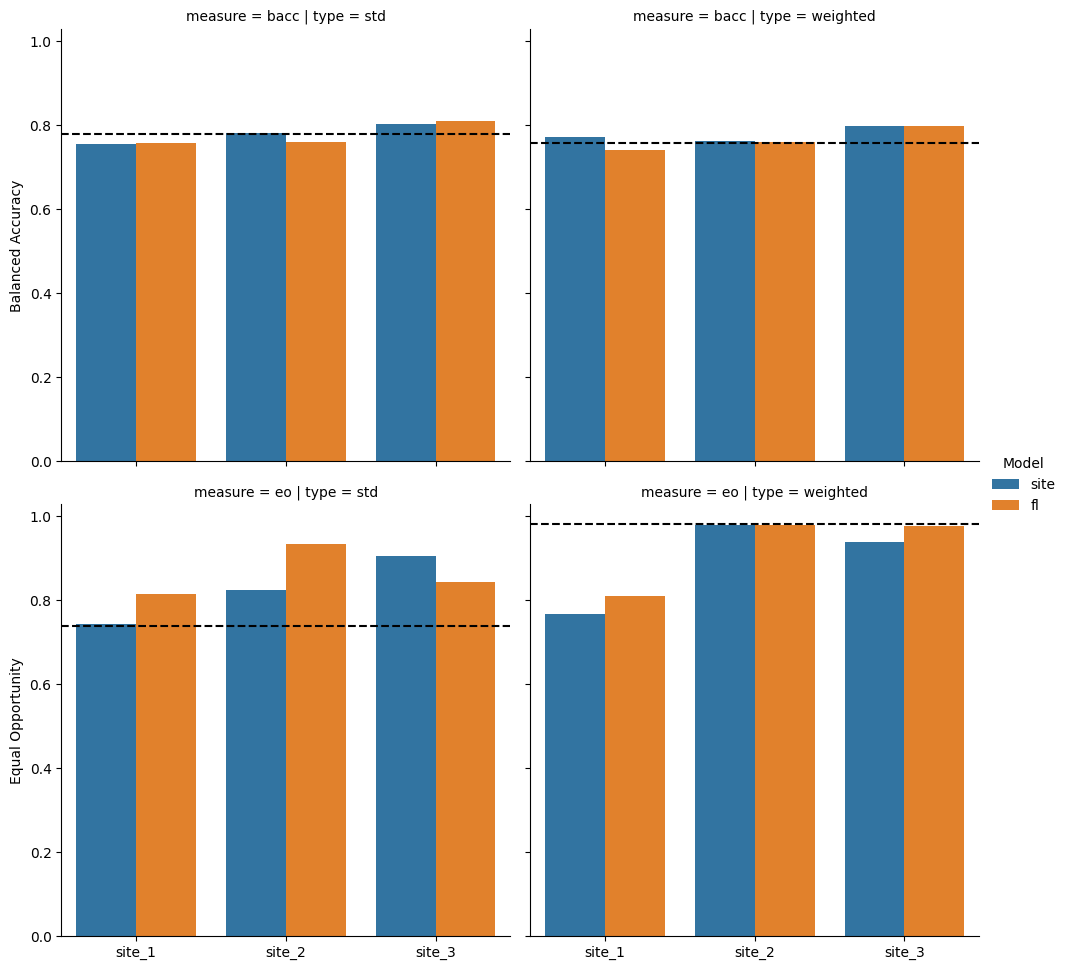

In [15]:
title_re = re.compile('measure = (\w+) \| type = (\w+)')

global_dict = global_df.to_dict()

g = sns.catplot(data=melted_comb_df, x='index', y='value', hue='model', col='type', row='measure', kind='bar', errorbar=None)

axes = g.axes.flatten()

for i, ax in enumerate(axes):
    title = ax.get_title()
    title_match = title_re.search(title)
    
    line_pos = global_dict[title_match.group(1) + '_' + title_match.group(2)]['overall']
    ax.axhline(line_pos, ls='--', c='black')
    if (title_match.group(1) == "bacc") and (title_match.group(2) == "std"): 
        ax.set_ylabel('Balanced Accuracy')
    elif (title_match.group(1) == "eo") and (title_match.group(2) == "std"):
        ax.set_ylabel('Equal Opportunity')

    ax.set_xlabel("")

g._legend.set(title='Model')

plt.show()

